In [1]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import controlSBML as csb

**comments**
1. Overall, very nice. 25/25.
1. Could you use the headings to make it easier to navigate the notebook. See what I did below.
1. You had a missing variable. (See comment below.) In the future, make sure that you do "kernel>Restart kernel and run all cells" before you submit the homework.

# BIOEN 599 Homework 1

BIOEN 599 Homework

Kazuki Fukumoto

Biomodel: BIOMD0000000924 (https://www.ebi.ac.uk/biomodels/BIOMD0000000924)

Paper: https://www.sciencedirect.com/science/article/pii/S0022519311000786

Problem description & control objectives 

The model is the immunological system responding to the infection of Pneumococci, which is the factor of pneumonia. It consists of Pneumococci, susceptible epithelial cells, epithelial cells with bacteria, cytokine, neutrophils, and debris (apoptotic cellular material). The result of its simulation shows that Pneumococci are not eliminated, and all epithelial cells go to zero. This would be because the employment of neutrophils through the epithelial cell with bacteria is not fast enough. As a result, the epithelial cells die before sufficient neutrophils are produced. Even if enough neutrophils are produced, large overshoots or oscillations of neutrophils could be the factor of other health problems. To overcome these problems, I set two following control objectives.

Control objectives are 
- shortening settling time so that neutrophils increases fast enought to eliminate Pneumococci
- not having the overshoot and oscillations of neutrophils

**Comment:** Nice problem statement.

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1808280007/6/Smith2011_V1.xml"
rr = te.loadSBMLModel(URL)
MODEL = rr.getAntimony()
print(MODEL)

// Created by libAntimony v2.13.2
function Rate_Law_for_reaction_for__EU_decay(omega, P, Eu)
  omega*P*Eu;
end

Rate_Law_for_reaction_for__EU_decay is "Rate Law for reaction for  EU decay"

function Rate_Law_for_reaction_for_Ea_decay(d_E, Ea)
  d_E*Ea;
end

Rate_Law_for_reaction_for_Ea_decay is "Rate Law for reaction for Ea decay"

function Rate_Law_for_reaction_for_P_Decay(gamma_M_A, f_P_M_A, kd, D, M_Astar, P, gamma_N, N)
  (gamma_M_A*f_P_M_A/(1 + kd*D*M_Astar))*M_Astar*P + gamma_N*N*P;
end

Rate_Law_for_reaction_for_P_Decay is "Rate Law for reaction for P Decay"

function Rate_Law_for_reaction_for__P_production(r, P, Kp)
  r*P*(1 - P/Kp);
end

Rate_Law_for_reaction_for__P_production is "Rate Law for reaction for  P production"

function Rate_Law_for_reaction_for_C_decay(dc, C)
  dc*C;
end

Rate_Law_for_reaction_for_C_decay is "Rate Law for reaction for C decay"

function Rate_Law_for_reaction_for_C_production(alpha, Ea, kn, N, v, theta_M, M_Astar, d, k, P)
  alpha*(Ea/(1 + kn*N)) + 

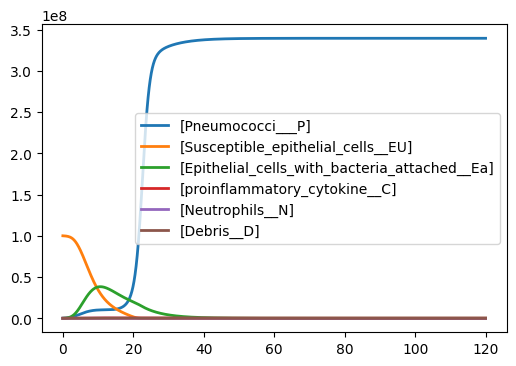

In [3]:
rr = te.loada(MODEL)
rr.simulate(start=0, end=120, steps=1200)
rr.plot()

In [4]:
ctlsb = csb.ControlSBML(MODEL)
print(ctlsb.getPossibleInputs())

floating_species:	Pneumococci___P, Susceptible_epithelial_cells__EU, Epithelial_cells_with_bacteria_attached__Ea, proinflammatory_cytokine__C, Neutrophils__N, Debris__D

parameter:	n, x, M_Astar, r, K_P, gamma_M_A, k_d, gamma_N, omega, d_E, alpha, k_n, v, theta_M, d, kappa, d_C, eta, N_max, d_NP, d_N, rho1, rho2, rho3, d_D, s

assignment:	f_P_M_A, log_Pneumococcal__P


**comment:** You are missing the assignment statement for the variable `ts`. See below.

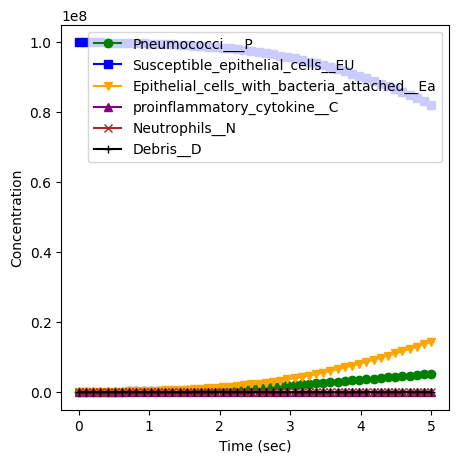

In [7]:
ts = ctlsb.plotModel()

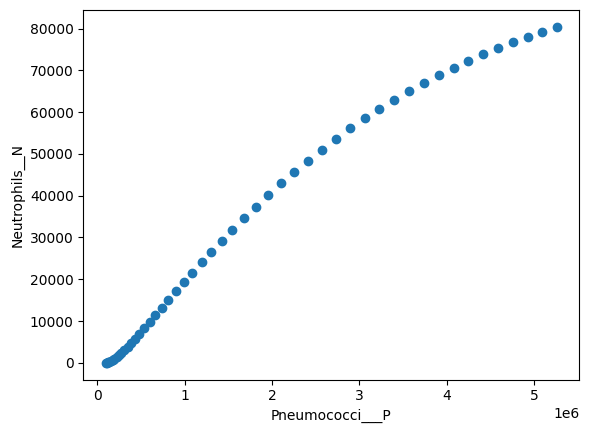

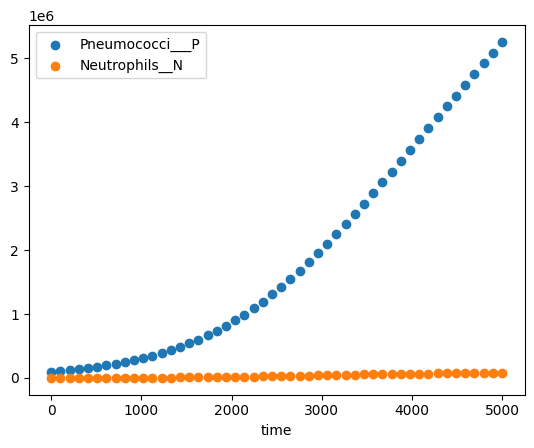

In [8]:
INPUT_NAME = 'Pneumococci___P'
OUTPUT_NAME = 'Neutrophils__N'

plt.scatter(ts[INPUT_NAME], ts[OUTPUT_NAME])
plt.xlabel(INPUT_NAME)
plt.ylabel(OUTPUT_NAME)
plt.show()

plt.scatter(ts.index, ts[INPUT_NAME])
plt.scatter(ts.index, ts[OUTPUT_NAME])
plt.xlabel("time")
plt.legend([INPUT_NAME, OUTPUT_NAME])
plt.show()

**comment:** Nice use of a script to look for the right time range. Powers of 10 are always a good starting point.

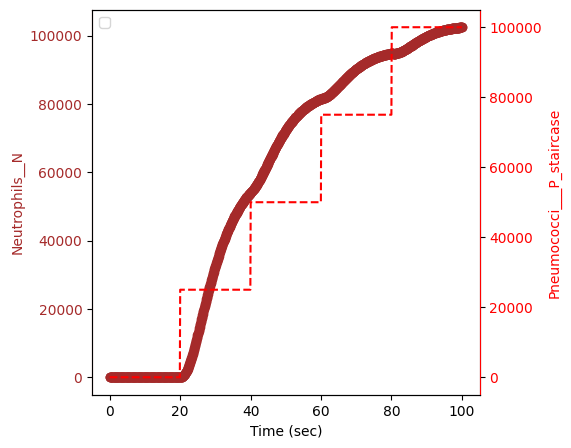

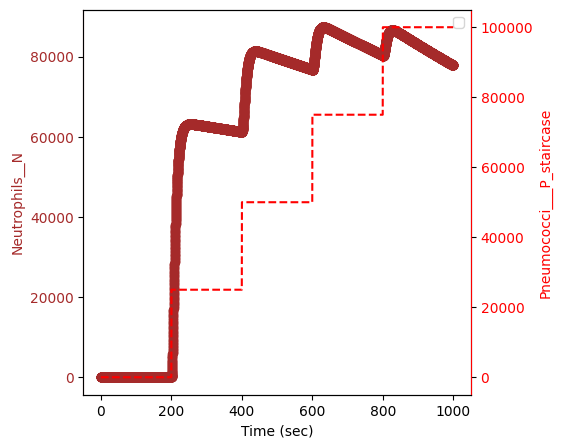

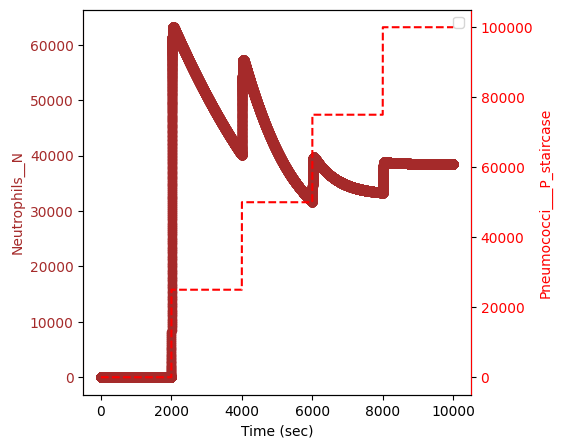

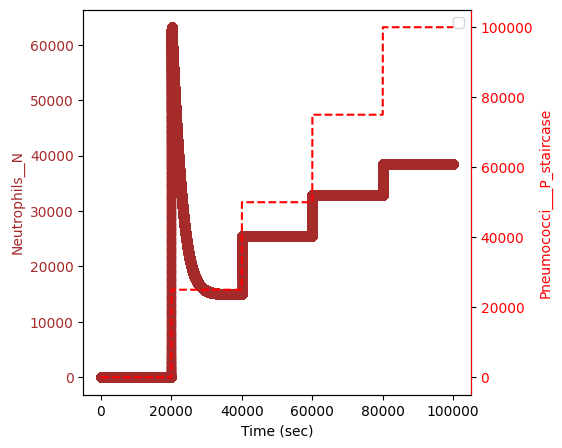

In [9]:
ctlsb = csb.ControlSBML(MODEL, input_names=[INPUT_NAME], output_names=[OUTPUT_NAME],
                    is_fixed_input_species=True)

finalValue = 100000
for time in [100, 1000, 10000, 100000]:
    resultTS, builder = ctlsb.plotStaircaseResponse(initial_value = 0, final_value = finalValue, num_step = 4, 
                                                    times=np.linspace(0, time, time*10))

In [10]:
print(resultTS)

             Neutrophils__N  Pneumococci___P_staircase
miliseconds                                           
0                  0.000000                        0.0
100                0.000000                        0.0
200                0.000000                        0.0
300                0.000000                        0.0
400                0.000000                        0.0
...                     ...                        ...
99999599       38487.995479                   100000.0
99999699       38487.995479                   100000.0
99999799       38487.995479                   100000.0
99999899       38487.995479                   100000.0
100000000      38487.995479                   100000.0

[1000000 rows x 2 columns]


Definition of the system

1. SBML model: BIOMD0000000924
1. input: Pneumococci___P (bacteria)
1. output: Neutrophils__N (leukocyte)
1. directional effect of the input on the output: increases
1. operating region for the input: [0, 100000]
1. range of outputs that can be achieved: [0, 38488]

On the plots, I changed the time length from 100 to 100000. When the time was too short, the output species did not settle to steady states. When the time was long, the output species settled. Therefore, the problem of unsettling in short time can be solved by shortening the settling time with controllers. 

In terms of overshoots, the number of overshoots decreased as the time got longer. So, I think the problem of overshoots can also be solved by the implementation of controllers. 